# Final Project - Ensemble NLP for Disaster Tweets
#### Team: Mayank Bambal, Muhammad Murtaza Shafiq

This project aims to build an effective machine learning model to predict whether a tweet is about a real disaster or not. The task was part of a Kaggle competition, and the goal was to leverage Natural Language Processing (NLP) techniques—especially transformer-based models—to classify tweets accurately during crises.

## 1. Data Import and Exploratory Data Analysis

### Library Imports
The code begins by importing essential libraries for data manipulation, visualization, and natural language processing:

In [ ]:
# Import necessary libraries for data manipulation and processing
import numpy as np
import pandas as pd
import re
import os
import tensorflow as tf
import keras as keras
import keras_nlp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

### Data Loading
We load the training and test datasets from Kaggle's "Natural Language Processing with Disaster Tweets" competition:

In [58]:
# Display available files in the Kaggle input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [59]:
# Load training and test datasets
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

### Data Overview and Statistics

Initial exploration of the dataset provides insights into its structure and characteristics:

In [60]:
# Print dataset shapes and memory usage
print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024**2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024**2:.2f} MB')

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [61]:
# Add a new column to calculate the length of each tweet
df_train["length"] = df_train["text"].apply(lambda x: len(x))
df_test["length"] = df_test["text"].apply(lambda x: len(x))

# Display statistical summary of tweet lengths
print("Train Length Stat")
print(df_train["length"].describe())
print()
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


This analysis reveals important characteristics:

- The training set contains 7,613 tweets with 5 features

- The test set consists of 3,263 tweets with 4 features

- The average tweet length is about 101 characters in the training set

In [62]:
df_train[['text','target']].iloc[31]

text      @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                    1
Name: 31, dtype: object

### Data Cleaning and Preprocessing

Text Preprocessing Function: s
To prepare the text data for the models, we implement several preprocessing functions:

In [63]:
# Define a function to remove links from tweets
def remove_links(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Apply link removal function to both train and test datasets
df_train['text'] = df_train['text'].apply(remove_links)
df_test['text'] = df_test['text'].apply(remove_links)

In [64]:
df_train[['text','target']].iloc[21]

text      London is cool ;)
target                    0
Name: 21, dtype: object

In [65]:
# Define a function to remove emojis from tweets
def demojize(tweet):
    # Regular expression to match emojis and symbols
    emoji_pattern = re.compile(
        u"[\U0001F600-\U0001F64F"   # Emoticons
        u"\U0001F300-\U0001F5FF"   # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"   # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"   # Flags (iOS)
        u"\U00002702-\U000027B0"   # Miscellaneous symbols
        u"\U000024C2-\U0001F251"   # Enclosed characters
        "]+", flags=re.UNICODE
    )
    
    # Remove emojis using the compiled regex
    cleaned_text = emoji_pattern.sub(r'', tweet)
    
    return cleaned_text

# Apply function to both train and test datasets
df_train['text'] = df_train['text'].apply(demojize)
df_test['text'] = df_test['text'].apply(demojize)


# Define a function to expand contractions like "don't" to "do not"
def remove_text_emoticons(tweet):
    # Regular expression to match common text-based emoticons
    emoticon_pattern = re.compile(
        r'(:\)|:-\)|:D|:P|:-P|;\)|;-\)|:O|:-O|:\/|:-\/|\(:|\):|<3|\^_\^|\(Y\))', 
        flags=re.UNICODE
    )
    
    # Remove emoticons
    cleaned_text = emoticon_pattern.sub('', tweet)
    
    return cleaned_text

# Apply contraction expansion function to both train and test datasets
df_train['text'] = df_train['text'].apply(remove_text_emoticons)
df_test['text'] = df_test['text'].apply(remove_text_emoticons)

In [66]:
df_train[['text','target']].iloc[86]

text      FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...
target                                                    1
Name: 86, dtype: object

### Abbreviation Expansion
To improve the model's understanding of tweets, we expand common abbreviations:

In [67]:
# Define a dictionary mapping common abbreviations to their expanded forms.
# This dictionary is used to replace abbreviations in tweets with their full meanings,
# improving the readability and understanding of the text data.
abbr_dict = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek You",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your Sex And Age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That Feeling When",
    "MFW": "My Face When",
    "MRW": "My Reaction When",
    "IFYP": "I Feel Your Pain",
    "TNTL": "Trying Not To Laugh",
    "JK": "Just Kidding",
    "IDC": "I Don’t Care",
    "ILY": "I Love You",
    "IMU": "I Miss You",
    "ADIH": "Another Day In Hell",
    "ZZZ": "Sleeping, Bored, Tired",
    "WYWH": "Wish You Were Here",
    "TIME": "Tears In My Eyes",
    "BAE": "Before Anyone Else",
    "FIMH": "Forever In My Heart",
    "BSAAW": "Big Smile And A Wink",
    "BWL": "Bursting With Laughter",
    "BFF": "Best Friends Forever",
    "CSL": "Can’t Stop Laughing"
}

# Replace abbreviations in the 'text' column of both training and test datasets using the defined dictionary.
# This operation ensures that tweets with abbreviations are transformed into their expanded forms,
# making them more suitable for downstream NLP tasks such as sentiment analysis or classification.
df_train['text'] = df_train['text'].replace(abbr_dict, regex=True)
df_test['text'] = df_test['text'].replace(abbr_dict, regex=True)

In [68]:
df_train[['text','target']].iloc[86]

text      For Your Information CAD:For Your Information:...
target                                                    1
Name: 86, dtype: object

### Text Normalization
We normalize text by expanding contractions, removing accents, and converting to lowercase:

In [70]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [71]:
import contractions

# Define a function to expand contractions in a tweet
def expand_contractions(tweet):
    return contractions.fix(tweet)

# Apply contraction expansion to both train and test datasets
df_train['text'] = df_train['text'].apply(lambda x: expand_contractions(x))
df_test['text'] = df_test['text'].apply(lambda x: expand_contractions(x))

In [72]:
df_train[['text','target']].iloc[26]

text      Was in NYC last week!
target                        0
Name: 26, dtype: object

In [73]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [74]:
# Import unidecode for removing accents
import re
import unidecode

# Define a function to clean keywords by replacing %20 with space
def clean_keywords(keyword):
    cleaned = re.sub(r'%20', ' ', keyword)
    return cleaned

# Define a function to remove accents from text
def remove_accents(keyword):
    cleaned = unidecode.unidecode(keyword)
    return cleaned

# Define a function to remove punctuation from text
def remove_punctuation(keyword):
    cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]"," ",keyword)
    return cleaned

In [75]:
df_train[['text','target']].iloc[38]

text      Barbados #Bridgetown JAMAI SeeA ÛÒ Two cars s...
target                                                    1
Name: 38, dtype: object

In [76]:
# Apply text cleaning functions to both train and test datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_keywords(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_keywords(x))
df_train['text'] = df_train['text'].apply(lambda x: remove_accents(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_accents(x))
df_train['text'] = df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punctuation(x))

In [77]:
df_train[['text','target']].iloc[38]

text      Barbados  Bridgetown JAMAI SeeA UO Two cars se...
target                                                    1
Name: 38, dtype: object

In [78]:
# Convert text to lowercase
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

### Train-Validation Split
We split the data into training and validation sets to evaluate model performance:

In [79]:
from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y) for training data
X = df_train["text"]
y = df_train["target"]

# Split data into training and validation sets (80% train, 20% validation)
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42, stratify=y)

# Extract test features for prediction later
X_test = df_test["text"]

## 2. Model Development
## a. roBERTa

We implement the RoBERTa model, a powerful transformer-based architecture for NLP tasks:


In [82]:
import tensorflow as tf
import keras as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import AdamW

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.17.1
KerasNLP version: 0.18.1


### 1. Model and tokenizer initialization:


In [83]:
# Load RoBERTa tokenizer and model for sequence classification tasks
MODEL_NAME = "roberta-base"
tokenizer_roberta = RobertaTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### 2. Data tokenization function:


In [84]:
# Define function to tokenize texts using RoBERTa tokenizer
def tokenize_roberta(texts, labels, max_length=160):
    encodings = tokenizer_roberta(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    return encodings, tf.convert_to_tensor(labels, dtype=tf.int32)

### 3. Tokenize training and validation data:

In [86]:
# Tokenize training and validation data
train_encodings_roberta, train_labels_roberta = tokenize_roberta(X_train, y_train)
val_encodings_roberta, val_labels_roberta = tokenize_roberta(X_val, y_val)
fulltrain_encodings_roberta, fulltrain_labels_roberta = tokenize_roberta(X,y)

### 4. Model training configuration & training:

In [87]:
from transformers import TFRobertaForSequenceClassification, create_optimizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# ✅ Load Pretrained RoBERTa Model
MODEL_NAME = "roberta-base"
model_roberta = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)  # Set to 1 for binary classification

# ✅ Define Training Parameters
batch_size = 72
num_epochs = 10
steps_per_epoch = len(X) // batch_size
total_steps = steps_per_epoch * num_epochs

# ✅ Create Optimizer
optimizer, _ = create_optimizer(
    init_lr=2e-6,
    num_train_steps=total_steps,
    num_warmup_steps=int(0.1 * total_steps),
    weight_decay_rate=0.01
)

# ✅ Compile Model with BinaryCrossentropy
model_roberta.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # ✅ Correct loss function for binary classification
    metrics=["accuracy"]
)

# ✅ Train Model
model_roberta.fit(
    x={"input_ids": fulltrain_encodings_roberta["input_ids"], "attention_mask": fulltrain_encodings_roberta["attention_mask"]},
    y=fulltrain_labels_roberta,  # Ensure labels are shape (num_samples, 1)
    batch_size=batch_size,
    epochs=num_epochs
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
106/106 [==============================] - 98s 721ms/step - loss: 0.6933 - accuracy: 0.5703
Epoch 2/10
106/106 [==============================] - 76s 720ms/step - loss: 0.5334 - accuracy: 0.6988
Epoch 3/10
106/106 [==============================] - 76s 721ms/step - loss: 0.4139 - accuracy: 0.8256
Epoch 4/10
106/106 [==============================] - 76s 720ms/step - loss: 0.3897 - accuracy: 0.8359
Epoch 5/10
106/106 [==============================] - 76s 721ms/step - loss: 0.3754 - accuracy: 0.8432
Epoch 6/10
106/106 [==============================] - 76s 721ms/step - loss: 0.3633 - accuracy: 0.8509
Epoch 7/10
106/106 [==============================] - 76s 720ms/step - loss: 0.3563 - accuracy: 0.8549
Epoch 8/10
106/106 [==============================] - 76s 721ms/step - loss: 0.3523 - accuracy: 0.8559
Epoch 9/10
106/106 [==============================] - 76s 720ms/step - loss: 0.3509 - accuracy: 0.8575
Epoch 10/10
106/106 [==============================] - 76s 719ms/step - l

### 5. Performance Visualization

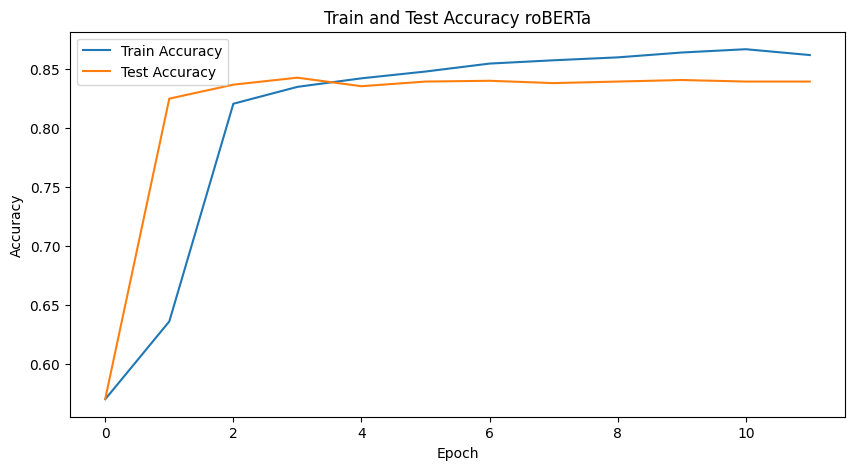

In [21]:
# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_roberta.history.history['accuracy'], label='Train Accuracy')
plt.plot(model_roberta.history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy roBERTa')
plt.show()

### 6. Model Evaluation and prediction

In [21]:
# Generate predictions on validation set
y_val_logits = model_roberta.predict({"input_ids": val_encodings_roberta["input_ids"], "attention_mask": val_encodings_roberta["attention_mask"]})
y_val_probs = tf.nn.sigmoid(y_val_logits.logits).numpy()

48/48 [==============================] - 7s 95ms/step


In [22]:
# Convert probabilities to class labels
y_val_labels = (y_val_probs > 0.5).astype(int).flatten()

F1 Score: 0.8028059236165237


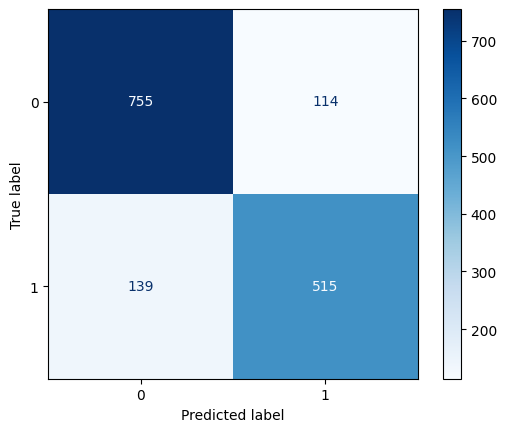

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_val, y_val_labels)
print(f"F1 Score: {f1}")

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [24]:
# prompt: print fpr tpr, fnr and tnr

from sklearn.metrics import confusion_matrix

# Assuming y_val and y_pred_labels are defined as in your original code
tn, fp, fn, tp = confusion_matrix(y_val, y_val_labels).ravel()

tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity)
fpr = fp / (fp + tn)  # False Positive Rate (1-Specificity)
fnr = fn / (fn + tp)  # False Negative Rate (1-Sensitivity)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)

print(f"TPR (Sensitivity): {tpr}")
print(f"FPR (1-Specificity): {fpr}")
print(f"FNR (1-Sensitivity): {fnr}")
print(f"TNR (Specificity): {tnr}")

TPR (Sensitivity): 0.7874617737003058
FPR (1-Specificity): 0.13118527042577677
FNR (1-Sensitivity): 0.21253822629969418
TNR (Specificity): 0.8688147295742232


In [88]:
# Prepare submission dataframe
submit_roberta = pd.DataFrame()
submit_roberta['id'] = df_test['id']

In [89]:
# Generate predictions on test set
test_encodings_roberta = tokenizer_roberta(df_test['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="tf")
y_roberta_logits = model_roberta.predict({"input_ids": test_encodings_roberta["input_ids"], "attention_mask": test_encodings_roberta["attention_mask"]})

102/102 [==============================] - 12s 94ms/step


In [90]:
# Convert logits to probabilities and then to class labels
y_roberta_probs = tf.nn.sigmoid(y_roberta_logits.logits).numpy()
y_roberta_labels = (y_roberta_probs > 0.5).astype(int).flatten()
submit_roberta['target'] = y_roberta_labels

# Save predictions to CSV file
submit_roberta.to_csv('/kaggle/working/submission_roberta.csv', index=False)

### 7. Model saving:

In [28]:
# Save trained model and tokenizer
save_directory = "./saved_roberta_tf_model"
model_roberta.save_pretrained(save_directory)
tokenizer_roberta.save_pretrained(save_directory)

('./saved_roberta_tf_model/tokenizer_config.json',
 './saved_roberta_tf_model/special_tokens_map.json',
 './saved_roberta_tf_model/vocab.json',
 './saved_roberta_tf_model/merges.txt',
 './saved_roberta_tf_model/added_tokens.json')

In [ ]:
# Load the fine-tuned model and tokenizer
load_directory = "./saved_roberta_tf_model"
model = TFBertForSequenceClassification.from_pretrained(load_directory)
tokenizer = BertTokenizer.from_pretrained(load_directory)

## b. DistillBERT

We implement DistilBERT, a distilled version of BERT that maintains good performance while being lighter and faster:

### 1. Model and tokenizer initialization:

In [91]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
tokenizer_dist = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Load pretrained DistilBERT classifier
model_distil = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = tokenizer_dist, 
                                                               num_classes=2)

model_distil.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Training configuration:

In [104]:
# Set training parameters
batch_size2 = 72
num_training_examples2= df_train.shape[0]
steps_per_epoch = int(num_training_examples2)*(1-val_split) // batch_size2

epochs2 = 17
AUTO = tf.data.experimental.AUTOTUNE

### 3. Model compilation and training:

In [105]:
# Compile model
model_distil.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(5e-7),
    metrics= ["accuracy"]  
)

# Train model
history_distil = model_distil.fit(x=X,
                         y=y,
                         batch_size=batch_size2,
                         epochs=epochs2
                          
                        )

Epoch 1/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 602ms/step - accuracy: 0.8466 - loss: 0.3882
Epoch 2/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - accuracy: 0.8509 - loss: 0.3836
Epoch 3/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - accuracy: 0.8482 - loss: 0.3809
Epoch 4/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - accuracy: 0.8512 - loss: 0.3789
Epoch 5/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8518 - loss: 0.3748
Epoch 6/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8510 - loss: 0.3726
Epoch 7/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8542 - loss: 0.3668
Epoch 8/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8534 - loss: 0.3650
Epoch 9/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8537 - loss: 0.3633
Epoch 10/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8590 - loss: 0.3600
Epoch 11/17
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - accuracy: 0.8578 - loss: 0.3587
Epoch 12/17
106/106

### 4. Evaluation and prediction:

In [106]:
# Helper function to display confusion matrix
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

#### 5. Performance Prediction

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step


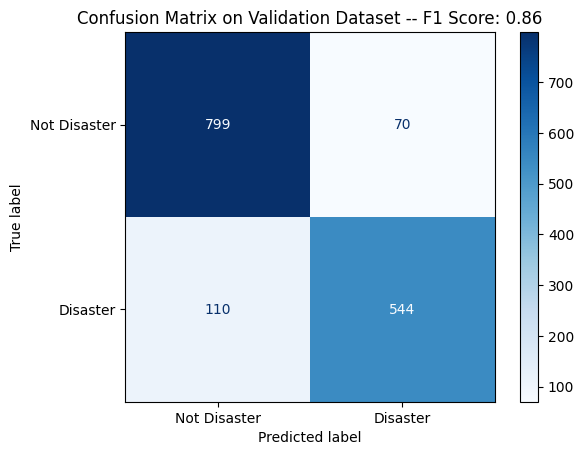

In [107]:
# Generate predictions and display confusion matrix
y_pred_val = model_distil.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [ ]:
# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_distil.history['accuracy'], label='Train Accuracy')
plt.plot(history_distil.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy roBERTa')
plt.show()

### 6. Model Saving

In [108]:
# Prepare submission dataframe
submission_distil = pd.DataFrame()
submission_distil['id'] = df_test['id']
submission_distil["target"] = np.argmax(model_distil.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step


In [109]:
# Save predictions to CSV file
submission_distil.to_csv("submission_distil.csv",index=False)

## c. deBERTa

We implement Microsoft's DeBERTa model, which enhances BERT with disentangled attention mechanisms:

In [112]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, create_optimizer

### 1. Model and tokenizer initialization:

In [113]:
# Load deBERTa tokenizer and model for sequence classification tasks
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer_deberta = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### 2. 2. Data tokenization function:

In [114]:
# Define function to tokenize texts using DeBERTa tokenizer
def tokenize_deberta(texts, labels, max_length=160):
    encodings = tokenizer_deberta(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    return encodings, tf.convert_to_tensor(labels, dtype=tf.int32)

### 3. Tokenize training and validation data

In [115]:
# Tokenize training and validation data
train_encodings_deberta, train_labels_deberta = tokenize_deberta(X_train, y_train)
test_encodings_deberta, test_labels_deberta = tokenize_deberta(X_val, y_val)
fulltrain_encodings_deberta, fulltrain_labels_deberta = tokenize_deberta(X, y)

### 4. Model training configuration & training:

In [121]:
# ✅ Load Pretrained DeBERTa Model for Binary Classification
model_deberta = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)  # num_labels=1 for BCE Loss

# ✅ Learning Rate Schedule
batch_size3 = 72
num_epochs3 = 17
steps_per_epoch3 = len(X_train) // batch_size3
total_steps3 = steps_per_epoch3 * num_epochs3

optimizer, _ = create_optimizer(
    init_lr=1e-6,  # Initial Learning Rate
    num_train_steps=total_steps3,
    num_warmup_steps=int(0.1 * total_steps3),
    weight_decay_rate=0.01
)

# ✅ Compile Model
model_deberta.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # BCE Loss for single output
    metrics=["accuracy"]
)

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier', 'pooler', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [123]:
# Train Model
model_deberta.fit(
    x={"input_ids": fulltrain_encodings_deberta["input_ids"], "attention_mask": fulltrain_encodings_deberta["attention_mask"]},
    y=fulltrain_labels_deberta,  # Ensure labels are shape (num_samples, 1)
    batch_size=batch_size3,
    epochs=num_epochs3
)

Epoch 1/17
106/106 [==============================] - 77s 725ms/step - loss: 0.3678 - accuracy: 0.8488
Epoch 2/17
106/106 [==============================] - 77s 730ms/step - loss: 0.3659 - accuracy: 0.8529
Epoch 3/17
106/106 [==============================] - 77s 727ms/step - loss: 0.3713 - accuracy: 0.8475
Epoch 4/17
106/106 [==============================] - 77s 727ms/step - loss: 0.3685 - accuracy: 0.8491
Epoch 5/17
106/106 [==============================] - 77s 728ms/step - loss: 0.3675 - accuracy: 0.8489
Epoch 6/17
106/106 [==============================] - 77s 729ms/step - loss: 0.3675 - accuracy: 0.8479
Epoch 7/17
106/106 [==============================] - 77s 730ms/step - loss: 0.3648 - accuracy: 0.8514
Epoch 8/17
106/106 [==============================] - 77s 728ms/step - loss: 0.3709 - accuracy: 0.8487
Epoch 9/17
106/106 [==============================] - 78s 731ms/step - loss: 0.3657 - accuracy: 0.8495
Epoch 10/17
106/106 [==============================] - 77s 730ms/step - l

### 5. Performance Visualization

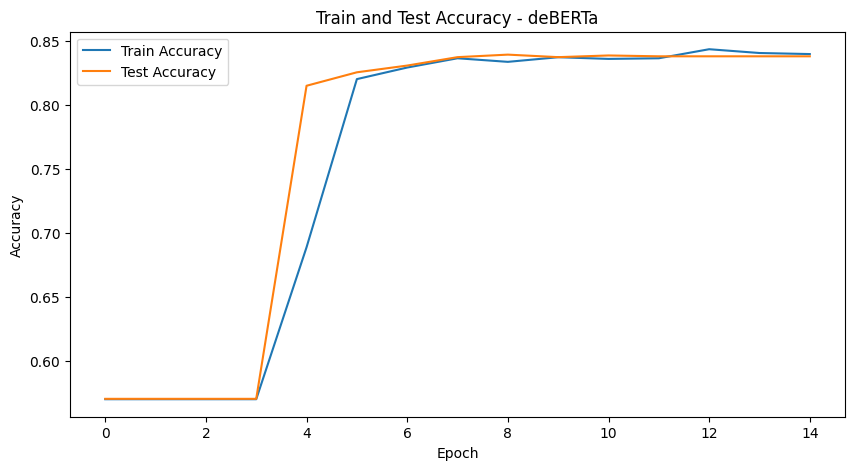

In [35]:
# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_deberta.history.history['accuracy'], label='Train Accuracy') # Access history data using history.history
plt.plot(model_deberta.history.history['val_accuracy'], label='Test Accuracy') # Access history data using history.history
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy - deBERTa')
plt.show()

### 6. Model Evaluation and prediction

In [124]:
# Generate predictions on validation set
y_deberta_logits = model_deberta.predict({"input_ids": test_encodings_deberta["input_ids"], "attention_mask": test_encodings_deberta["attention_mask"]})
y_deberta_probs = tf.nn.sigmoid(y_deberta_logits.logits).numpy()
# Convert probabilities to class labels
y_deberta_labels = (y_deberta_probs > 0.5).astype(int).flatten()

48/48 [==============================] - 9s 95ms/step


F1 Score: 0.8050117462803444


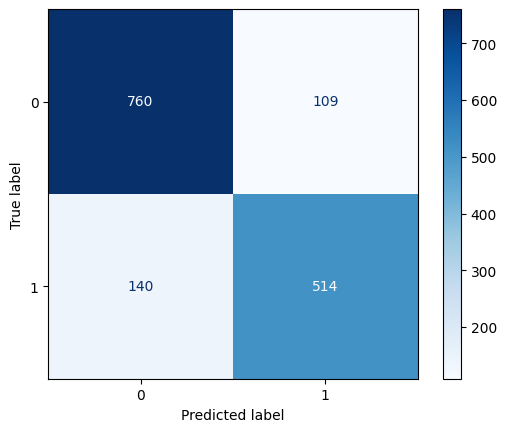

In [37]:
# Calculate the F1 score
f1 = f1_score(y_val, y_deberta_labels)
print(f"F1 Score: {f1}")

# Create the confusion matrix
cm = confusion_matrix(y_val, y_deberta_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [125]:
test_encodings_deberta = tokenizer_deberta(df_test['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="tf")
y_deberta_logits = model_deberta.predict({"input_ids": test_encodings_deberta["input_ids"], "attention_mask": test_encodings_deberta["attention_mask"]})
y_deberta_probs = tf.nn.sigmoid(y_deberta_logits.logits).numpy()
y_deberta_labels = (y_deberta_probs > 0.5).astype(int).flatten()

102/102 [==============================] - 10s 95ms/step


In [126]:
# Prepare submission dataframe
submit_deberta = pd.DataFrame()
submit_deberta['id'] = df_test['id']

### 7. Model saving:

In [127]:
# Save trained model and tokenizer
save_directory = "./saved_deberta_tf_model"
model_deberta.save_pretrained(save_directory)
tokenizer_deberta.save_pretrained(save_directory)

('./saved_deberta_tf_model/tokenizer_config.json',
 './saved_deberta_tf_model/special_tokens_map.json',
 './saved_deberta_tf_model/spm.model',
 './saved_deberta_tf_model/added_tokens.json',
 './saved_deberta_tf_model/tokenizer.json')

In [128]:
# Save predictions to CSV file
submit_deberta['target'] = y_deberta_labels
submit_deberta.to_csv('/kaggle/working/submission_deberta.csv', index=False)

## 3. Ensembling Models for Improved Predictions

In [129]:
import pandas as pd
from collections import Counter

# Load submission files (replace 'submission1.csv', 'submission2.csv', 'submission3.csv' with actual file names)
sub1 = pd.read_csv("submission_deberta.csv")
sub2 = pd.read_csv("submission_roberta.csv")
sub3 = pd.read_csv("submission_distil.csv")

# Ensure they have the same structure
assert list(sub1.columns) == list(sub2.columns) == list(sub3.columns), "Column names do not match!"

# Assuming the prediction column name is 'label' (change if needed)
prediction_column = "target"

# Stack predictions and apply majority voting
final_predictions = []
for preds in zip(sub1[prediction_column], sub2[prediction_column], sub3[prediction_column]):
    most_common = Counter(preds).most_common(1)[0][0]  # Get the most frequent prediction
    final_predictions.append(most_common)

# Create final submission dataframe
final_submission = sub1.copy()
final_submission[prediction_column] = final_predictions

# Save to CSV
final_submission.to_csv("final_submission.csv", index=False)

## Thank you